I fixed the TPCF issues, but now the delta sigma projection integration is being troublesome. I'm gonna do them for a few rp_bins to figure out what is sensible agian. 

In [1]:
import numpy as np
from glob import glob
from os import path

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import matplotlib.colors as colors

In [3]:
from pearce.mocks.kittens import DarkSky
from pearce.mocks import tpcf as pearce_tpcf
from halotools.mock_observables import tpcf as halotools_tpcf
from halotools.empirical_models import Zheng07Cens, Zheng07Sats
from collections import OrderedDict
from time import time
from scipy.optimize import minimize_scalar
import yaml

In [4]:
output_dir = './'# '/home/users/swmclau2/Git/pearce/bin/covmat/ds14_covmat/'

In [5]:
config_fname = 'xi_cosmo_trainer.yaml'

with open(path.join(output_dir, config_fname), 'r') as ymlfile:
    cfg = yaml.load(ymlfile)

nd = float(cfg['HOD']['fixed_nd'] )
min_ptcl = int(cfg['HOD']['min_ptcl'])
r_bins = np.array(cfg['observation']['bins'] ).astype(float)

hod_param_ranges =  cfg['HOD']['ordered_params']


logMmin_bounds = hod_param_ranges['logMmin']


del hod_param_ranges['logMmin']

In [6]:
def make_LHC(ordered_params, N, seed = None):

    if seed is None:
        seed = int(time())
    np.random.seed(seed)

    points = []
    # by linspacing each parameter and shuffling, I ensure there is only one point in each row, in each dimension.
    for plow, phigh in ordered_params.itervalues():
        point = np.linspace(plow, phigh, num=N)
        np.random.shuffle(point)  # makes the cube random.
        points.append(point)
    return np.stack(points).T


def add_logMmin(hod_params, cat):

    hod_params['logMmin'] = 13.0 #initial guess
    #cat.populate(hod_params) #may be overkill, but will ensure params are written everywhere
    def func(logMmin, hod_params):
        hod_params.update({'logMmin':logMmin})
        return (cat.calc_analytic_nd(hod_params, min_ptcl = min_ptcl) - nd)**2

    res = minimize_scalar(func, bounds = logMmin_bounds, args = (hod_params,), options = {'maxiter':100}, method = 'Bounded')

    # assuming this doens't fail
    #print 'logMmin', res.x
    hod_params['logMmin'] = res.x

In [7]:
from pearce.mocks.kittens import TestBox
cat = TestBox(boxno = 0, realization = 0, system = 'sherlock')
cat.load(1.0, HOD='zheng07', particles = True, downsample_factor = 1e-2)

In [8]:
# TODO seed here for constant HODs
# TODO maybe just do 5, 10 may be overkill
N = 10
LHC = make_LHC(hod_param_ranges, N, 24)
hod_dicts = [dict(zip(hod_param_ranges.keys(), vals)) for vals in LHC]

In [9]:
cat.populate(hod_dicts[1])

In [10]:
cat._get_cosmo_param_names_vals()

(['ombh2', 'omch2', 'w0', 'ns', 'ln10As', 'H0', 'Neff'],
 array([  2.32629000e-02,   1.07830000e-01,  -7.26513000e-01,
          9.80515000e-01,   3.03895000e+00,   6.32317000e+01,
          2.95000000e+00]))

In [11]:
from halotools.mock_observables import return_xyz_formatted_array, delta_sigma, tpcf

In [12]:
def calc_ds(cat, bins):
    #n_cores = self._check_cores(n_cores)
    n_cores = 2
    
    x_g, y_g, z_g = [cat.model.mock.galaxy_table[c] for c in ['x', 'y', 'z']]
    pos_g = return_xyz_formatted_array(x_g, y_g, z_g, period=cat.Lbox)

    x_m, y_m, z_m = [cat.halocat.ptcl_table[c] for c in ['x', 'y', 'z']]
    pos_m = return_xyz_formatted_array(x_m, y_m, z_m, period=cat.Lbox)

    rp_bins = bins #if not angular else self._rp_from_ang(bins)

    # Halotools wnats downsampling factor defined oppositley
    # TODO verify little h!
    # TODO maybe split into a few lines for clarity
    return delta_sigma(pos_g / cat.h, pos_m / cat.h, cat.pmass / cat.h,
                   downsampling_factor=1. / cat._downsample_factor, rp_bins=rp_bins,
                   period=cat.Lbox / cat.h, num_threads=n_cores, cosmology=cat.cosmology)[1] / (1e12)


In [13]:
from scipy.interpolate import interp1d
#import pyccl as ccl
from scipy.integrate import quad

In [14]:
from halotools.mock_observables import delta_sigma_from_precomputed_pairs
from halotools.mock_observables import  total_mass_enclosed_per_cylinder as tmepc_halotools
from halotools.mock_observables.surface_density.mass_in_cylinders import _enclosed_mass_process_args
from halotools.mock_observables.surface_density.weighted_npairs_per_object_xy import weighted_npairs_per_object_xy

In [15]:
def total_mass_enclosed_per_cylinder(centers, particles,
        particle_masses, downsampling_factor, rp_bins, period,
        num_threads=1, approx_cell1_size=None, approx_cell2_size=None):

#  Perform bounds-checking and error-handling in private helper functions
    #print period
    args = (centers, particles, particle_masses, downsampling_factor,
        rp_bins, period, num_threads)
    result = _enclosed_mass_process_args(*args)
    centers, particles, particle_masses, downsampling_factor, \
        rp_bins, period, num_threads, PBCs = result

    #print 'PBCs:', PBCs
    #print 'Period:', period
    #period = None
    mean_particle_mass = np.mean(particle_masses)
    normalized_particle_masses = particle_masses/mean_particle_mass

    # Calculate M_tot(< Rp) normalized with internal code units
    total_mass_per_cylinder = weighted_npairs_per_object_xy(centers, particles,
        normalized_particle_masses, rp_bins,
        period=None, num_threads=num_threads, #try large finite PBCs
        approx_cell1_size=approx_cell1_size,
        approx_cell2_size=approx_cell2_size)

    # Renormalize the particle masses and account for downsampling
    total_mass_per_cylinder *= downsampling_factor*mean_particle_mass

    return total_mass_per_cylinder


In [16]:
def calc_tm(cat, bins):
    #n_cores = self._check_cores(n_cores)
    n_cores = 4
    
    x_g, y_g, z_g = [cat.model.mock.galaxy_table[c] for c in ['x', 'y', 'z']]
    pos_g = return_xyz_formatted_array(x_g, y_g, z_g, period=cat.Lbox)

    x_m, y_m, z_m = [cat.halocat.ptcl_table[c] for c in ['x', 'y', 'z']]
    pos_m = return_xyz_formatted_array(x_m, y_m, z_m, period=cat.Lbox)

    rp_bins = bins #if not angular else self._rp_from_ang(bins)
    tm = total_mass_enclosed_per_cylinder(pos_g/cat.h, pos_m/cat.h, cat.pmass/cat.h,\
                                     1./cat._downsample_factor, rp_bins,# cat.Lbox/cat.h,\
                                          cat.Lbox/cat.h,\
                                         num_threads = n_cores)
    print 
    tm_ht = tmepc_halotools(pos_g/cat.h, pos_m/cat.h, cat.pmass/cat.h,\
                                     1./cat._downsample_factor, rp_bins,# cat.Lbox/cat.h,\
                                          cat.Lbox/cat.h,\
                                         num_threads = n_cores)
    
    return tm, tm_ht

In [17]:
def calc_ds2(cat, bins, tm):
    
    x_g, y_g, z_g = [cat.model.mock.galaxy_table[c] for c in ['x', 'y', 'z']]
    pos_g = return_xyz_formatted_array(x_g, y_g, z_g, period=cat.Lbox)

   
    ds = delta_sigma_from_precomputed_pairs(pos_g / cat.h, tm, bins, \
                                              cat.Lbox/cat.h, cosmology=cat.cosmology)[1] / (1e12)
    
    return ds

In [18]:
rp_bins = np.logspace(-0.5, 2.0, 11)

In [19]:
names, vals = cat._get_cosmo_param_names_vals()
param_dict = {n: v for n, v in zip(names, vals)}

new_param_dict = {}
new_param_dict['Omega_c'] = param_dict['omch2']/cat.h**2
new_param_dict['Omega_b'] = param_dict['ombh2']/cat.h**2
new_param_dict['n_s'] = param_dict['ns']
new_param_dict['h'] = cat.h
new_param_dict['A_s'] = np.exp(param_dict['ln10As'])/(np.power(10, 10))

In [20]:
param_dict

{'H0': 63.231699999999996,
 'Neff': 2.9500000000000002,
 'ln10As': 3.0389499999999998,
 'ns': 0.98051499999999991,
 'ombh2': 0.023262900000000003,
 'omch2': 0.10783,
 'w0': -0.72651299999999996}

In [21]:
new_param_dict

{'A_s': 2.0883304249678889e-09,
 'Omega_b': 0.058182735712595794,
 'Omega_c': 0.26969313335350292,
 'h': 0.632317,
 'n_s': 0.98051499999999991}

In [22]:
rp_bins

array([   0.31622777,    0.56234133,    1.        ,    1.77827941,
          3.16227766,    5.62341325,   10.        ,   17.7827941 ,
         31.6227766 ,   56.23413252,  100.        ])

In [23]:
tm, tm_ht = calc_tm(cat, rp_bins)

In [24]:
ds = calc_ds2(cat, rp_bins, tm)

In [26]:
print ds

[ 22.67152071  12.91536306   6.73179328   3.23496689   1.59690043
   0.94686751   0.71960138   0.6919193    0.83918369   1.24496502]


In [28]:
rp_bins

array([  0.31622777,   0.56234133,   1.        ,   1.77827941,
         3.16227766,   5.62341325,  10.        ,  17.7827941 ,
        31.6227766 ,  56.23413252, 100.        ])

In [42]:
tm.shape

(796509, 11)

In [77]:
idxs = cat.model.mock.galaxy_table['x'] < 10#, \
                    # cat.model.mock.galaxy_table['x'] > 999.99)

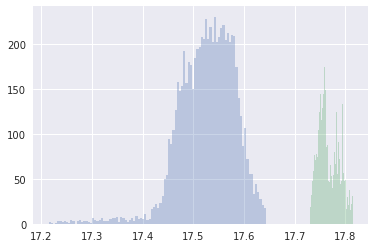

In [80]:
plt.hist(np.log10(tm[idxs,idx] + 1e-6) , bins = 100, alpha = 0.3, label = 'No PBC');
plt.hist(np.log10(tm_ht[idxs,idx] + 1e-6) , bins = 100, alpha = 0.3, label = 'PBC');


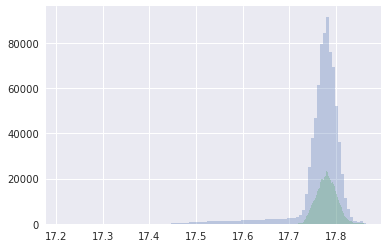

In [79]:
plt.hist(np.log10(tm[~idxs,idx] + 1e-6) , bins = 100, alpha = 0.3);
plt.hist(np.log10(tm_ht[~idxs,idx] + 1e-6) , bins = 100, alpha = 0.3);


(array([3.0000e+00, 5.0000e+00, 1.0000e+00, 6.0000e+00, 7.0000e+00,
        5.0000e+00, 5.0000e+00, 7.0000e+00, 4.0000e+00, 9.0000e+00,
        1.0000e+01, 9.0000e+00, 8.0000e+00, 1.0000e+01, 1.2000e+01,
        1.6000e+01, 1.6000e+01, 1.0000e+01, 1.7000e+01, 2.2000e+01,
        1.7000e+01, 2.3000e+01, 2.1000e+01, 1.9000e+01, 2.6000e+01,
        3.1000e+01, 2.9000e+01, 3.5000e+01, 3.2000e+01, 5.1000e+01,
        4.8000e+01, 5.2000e+01, 7.3000e+01, 8.5000e+01, 1.1600e+02,
        1.7200e+02, 2.5400e+02, 3.2700e+02, 4.7000e+02, 5.9600e+02,
        7.1400e+02, 8.3700e+02, 9.4100e+02, 1.0300e+03, 1.0870e+03,
        1.1870e+03, 1.2830e+03, 1.2760e+03, 1.4350e+03, 1.3670e+03,
        1.3790e+03, 1.3930e+03, 1.4710e+03, 1.4870e+03, 1.5190e+03,
        1.5010e+03, 1.5990e+03, 1.5610e+03, 1.6280e+03, 1.6540e+03,
        1.6980e+03, 1.6800e+03, 1.7630e+03, 1.7520e+03, 1.7940e+03,
        1.9240e+03, 1.8970e+03, 1.9280e+03, 1.9770e+03, 2.0220e+03,
        2.0450e+03, 2.1780e+03, 2.2840e+03, 2.33

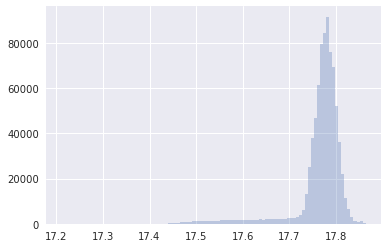

In [49]:
plt.hist(np.log10(tm[:,idx] + 1e-6) , bins = 100, alpha = 0.3);
plt.hist(np.log10(tm_ht[:,idx] + 1e-6) , bins = 100, alpha = 0.3);


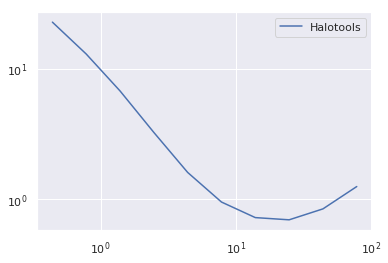

In [27]:
rpoints = (rp_bins[1:] + rp_bins[:-1])/2.0
plt.plot(rpoints, ds.squeeze(), label = 'Halotools')
#plt.plot(rpoints, ds2.squeeze(), label = 'Halotools 2')
#plt.plot(rpoints, ds2_ht.squeeze(), label = 'Halotools 3')

#plt.plot(rpoints, ds_analytic.squeeze(), label = 'Analytic')

plt.legend(loc='best')
plt.loglog();

In [ ]:
ds/ds2

In [ ]:
ds/ds2_ht

To test:
set period to large finite value
set all periods to none
run with larger rp bins to see if problems continue at larger scaels